In [10]:

!pip install -q torch torchvision torchaudio
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
^C


KeyboardInterrupt: 

In [2]:
task = 'graph'
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.data import DataLoader
import torch_geometric.nn as pyg_nn
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [3]:

if task == 'graph':
    dataset = TUDataset(root='data/TUDataset', name='MUTAG', use_node_attr=False, transform=T.NormalizeFeatures())

    n = len(dataset)
    n_train = int(0.8 * n)
    dataset = dataset.shuffle()
    train_dataset = dataset[:n_train]
    test_dataset = dataset[n_train:]
    print(f"Loaded MUTAG (graph classification). Total graphs: {len(dataset)} Train: {len(train_dataset)} Test: {len(test_dataset)}")
    loader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
    loader_test = DataLoader(test_dataset, batch_size=64, shuffle=False)
else:
    dataset = Planetoid(root='data/Planetoid', name='Cora', transform=T.NormalizeFeatures())
    data = dataset[0].to(device)

    print("Loaded Cora (node classification).")


Loaded MUTAG (graph classification). Total graphs: 188 Train: 150 Test: 38


Processing...
Done!
/tmp/ipython-input-3802731452.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
/tmp/ipython-input-3802731452.py:14: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader_test = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [5]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node', num_layers=3, dropout=0.25):
        super(GNNStack, self).__init__()
        assert task in ('node', 'graph')
        self.task = task
        self.num_layers = num_layers
        self.dropout = dropout

        self.convs = nn.ModuleList()
        self.lns = nn.ModuleList()

        self.convs.append(self.build_conv_model(input_dim, hidden_dim))

        for _ in range(1, num_layers):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        for _ in range(num_layers - 1):
            self.lns.append(nn.LayerNorm(hidden_dim))
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def build_conv_model(self, in_dim, out_dim):
        if self.task == 'node':
            return pyg_nn.GCNConv(in_dim, out_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.ReLU(),
                nn.Linear(out_dim, out_dim)
            ))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, 'batch', None)
        if x is None:
            x = torch.ones((data.num_nodes, 1), device=edge_index.device)

        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = self.lns[i](x)
        emb = x

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)
        out = self.post_mp(x)
        return emb, F.log_softmax(out, dim=1)

    def loss(self, pred_logprob, label):
        return F.nll_loss(pred_logprob, label)


In [6]:
if task == 'graph':
    input_dim = max(1, dataset.num_node_features)
    num_classes = dataset.num_classes
else:
    input_dim = max(1, dataset.num_node_features)
    num_classes = dataset.num_classes

model = GNNStack(input_dim=input_dim, hidden_dim=64, output_dim=num_classes, task=task, num_layers=3, dropout=0.25).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
print(model)


GNNStack(
  (convs): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=7, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (1-2): 2 x GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
  )
  (lns): ModuleList(
    (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (post_mp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [7]:
def train_graph_epoch(loader):
    model.train()
    total_loss = 0.0
    total_graphs = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        emb, pred = model(batch)
        loss = model.loss(pred, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
        total_graphs += batch.num_graphs
    return total_loss / total_graphs

@torch.no_grad()
def eval_graph(loader):
    model.eval()
    correct = 0
    total = 0
    for batch in loader:
        batch = batch.to(device)
        emb, pred = model(batch)
        pred_label = pred.argmax(dim=1)
        correct += (pred_label == batch.y).sum().item()
        total += batch.num_graphs
    return correct / total

def train_node_epoch(data):
    model.train()
    optimizer.zero_grad()
    emb, pred = model(data)
    loss = model.loss(pred[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def eval_node(data, mask='test'):
    model.eval()
    emb, pred = model(data)
    pred_label = pred.argmax(dim=1)
    if mask == 'test':
        m = data.test_mask
    elif mask == 'val':
        m = data.val_mask
    else:
        m = data.train_mask
    correct = (pred_label[m] == data.y[m]).sum().item()
    total = int(m.sum().item())
    return correct / total if total > 0 else 0.0


In [8]:
num_epochs = 100
train_losses = []
test_scores = []

if task == 'graph':
    for epoch in range(1, num_epochs + 1):
        loss = train_graph_epoch(loader_train)
        acc = eval_graph(loader_test)
        train_losses.append(loss)
        test_scores.append(acc)
        if epoch % 10 == 0 or epoch == 1:
            print(f"[Graph] Epoch {epoch:03d} | Loss: {loss:.4f} | Test Acc: {acc:.4f}")
else:
    data = data.to(device)
    for epoch in range(1, num_epochs + 1):
        loss = train_node_epoch(data)
        val_acc = eval_node(data, mask='val')
        test_acc = eval_node(data, mask='test')
        train_losses.append(loss)
        test_scores.append(test_acc)
        if epoch % 10 == 0 or epoch == 1:
            print(f"[Node] Epoch {epoch:03d} | Loss: {loss:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")


[Graph] Epoch 001 | Loss: 0.7703 | Test Acc: 0.7368
[Graph] Epoch 010 | Loss: 0.6542 | Test Acc: 0.7368
[Graph] Epoch 020 | Loss: 0.6517 | Test Acc: 0.7368
[Graph] Epoch 030 | Loss: 0.6599 | Test Acc: 0.7368
[Graph] Epoch 040 | Loss: 0.6446 | Test Acc: 0.7895
[Graph] Epoch 050 | Loss: 0.5697 | Test Acc: 0.7895
[Graph] Epoch 060 | Loss: 0.5325 | Test Acc: 0.7895
[Graph] Epoch 070 | Loss: 0.5074 | Test Acc: 0.7895
[Graph] Epoch 080 | Loss: 0.5559 | Test Acc: 0.8158
[Graph] Epoch 090 | Loss: 0.5174 | Test Acc: 0.8158
[Graph] Epoch 100 | Loss: 0.5285 | Test Acc: 0.7632


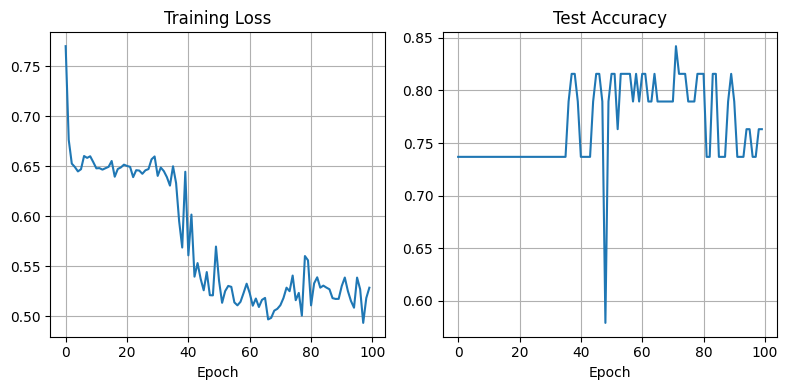

In [9]:

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title('Training Loss'); plt.xlabel('Epoch'); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(test_scores)
plt.title('Test Accuracy'); plt.xlabel('Epoch'); plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3011846513.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(dataset, batch_size=64, shuffle=False)


Embeddings shape: (188, 64) Labels shape: (188,)


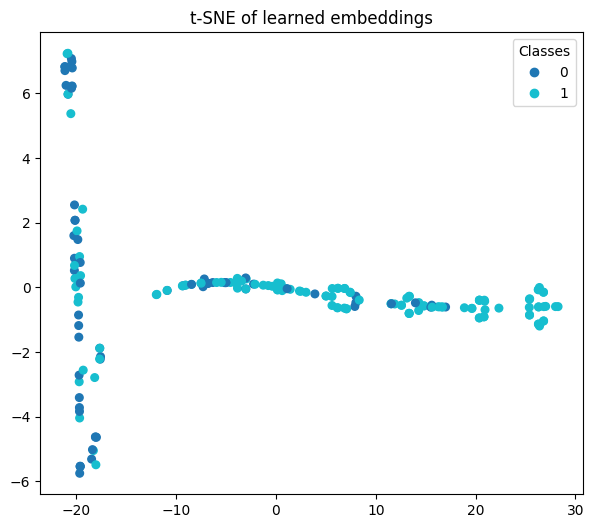

In [10]:
@torch.no_grad()
def get_embeddings_and_labels():
    model.eval()
    if task == 'graph':
        all_embs = []
        all_labels = []
        loader = DataLoader(dataset, batch_size=64, shuffle=False)
        for batch in loader:
            batch = batch.to(device)
            emb, pred = model(batch)
            g_emb = pyg_nn.global_mean_pool(emb, batch.batch)
            all_embs.append(g_emb.cpu())
            all_labels.append(batch.y.cpu())
        embs = torch.cat(all_embs, dim=0).numpy()
        labels = torch.cat(all_labels, dim=0).numpy()
    else:
        data_local = data.to(device)
        emb, pred = model(data_local)
        embs = emb.cpu().numpy()
        labels = data_local.y.cpu().numpy()
    return embs, labels

embs, labels = get_embeddings_and_labels()
print("Embeddings shape:", embs.shape, "Labels shape:", labels.shape)

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
emb2 = tsne.fit_transform(embs)

plt.figure(figsize=(7,6))
scatter = plt.scatter(emb2[:,0], emb2[:,1], c=labels, cmap='tab10', s=30)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('t-SNE of learned embeddings')
plt.show()
